### Testing the satellite code in _luseepy_

* Import prerequisites



In [1]:
import  numpy as np
import  matplotlib.pyplot as plt
import  h5py
import  lunarsky
from    lunarsky.time   import Time

from astropy.time import Time as myT
print(f'''lunarsky path: {lunarsky.__path__[0]}''')


lunarsky path: /home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages/lunarsky


In [2]:
import  lusee
from    lusee import Observation, Satellite, ObservedSatellite
print(f'''lusee path: {lusee.__path__[0]}''')

lusee path: /home/maxim/projects/lusee/luseepy/lusee


In [32]:
# Optional: if you need to read prefab data on the satellite orbit, do it here for testing

sat_file    = h5py.File('/home/maxim/foo.hdf5')
ds_data     = sat_file["/data/trajectory"]
sat_data    = np.array(ds_data[:]) # data array
times       = sat_data[:, 0]
traj        = sat_data[:, [1,2,3]]

print(times.shape)
print(traj.shape)

N = times.shape[0]

mjd = np.empty(N, dtype=myT)
for i in range(N):
   mjd[i] = Time(times[i], format='mjd')

# f = lambda x: Time(x, format='mjd')
# mjd = np.array(f(times))
# print(type(mjd), mjd.shape)

deltaT = (times[32]-times[31])*(24*3600)

print(f'deltaT_sec: {deltaT}')

(86002,)
(86002, 3)
deltaT_sec: 60.00000019557774


In [33]:
obs     = Observation(time_range=mjd, deltaT_sec=float(deltaT))

# obs     = Observation(time_range=interval, deltaT_sec=15*60)
S       = traj # Satellite()
obsat   = ObservedSatellite(obs, S)



[<Time object: scale='utc' format='mjd' value=61011.336493055554>
 <Time object: scale='utc' format='mjd' value=61011.33718501157>
 <Time object: scale='utc' format='mjd' value=61011.33787945602> ...
 <Time object: scale='utc' format='mjd' value=61071.058018344906>
 <Time object: scale='utc' format='mjd' value=61071.05871278935>
 <Time object: scale='utc' format='mjd' value=61071.05905092593>]


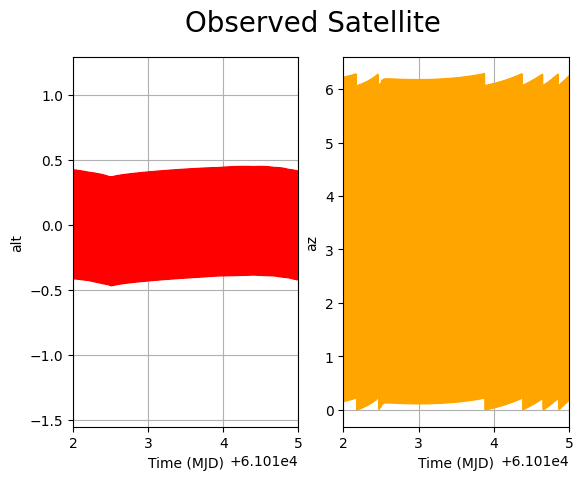

In [34]:

fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Observed Satellite', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


#p1=plt.subplot()
p1.grid(True)
p2.grid(True)

#p1.set_xlim([60715,60730])
#p2.set_xlim([60715,60730])

p1.set_xlim([61012,61015])
p2.set_xlim([61012,61015])

p1.set_xlabel('Time (MJD)')
p1.set_ylabel('alt')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('az')

_ = p1.plot(obsat.mjd, obsat.alt,  color="red", label="Satellite")
_ = p2.plot(obsat.mjd, obsat.az,   color="orange", label="Satellite")

---

### Plot the trajectory

Test plot with canonical settings, for back reference.


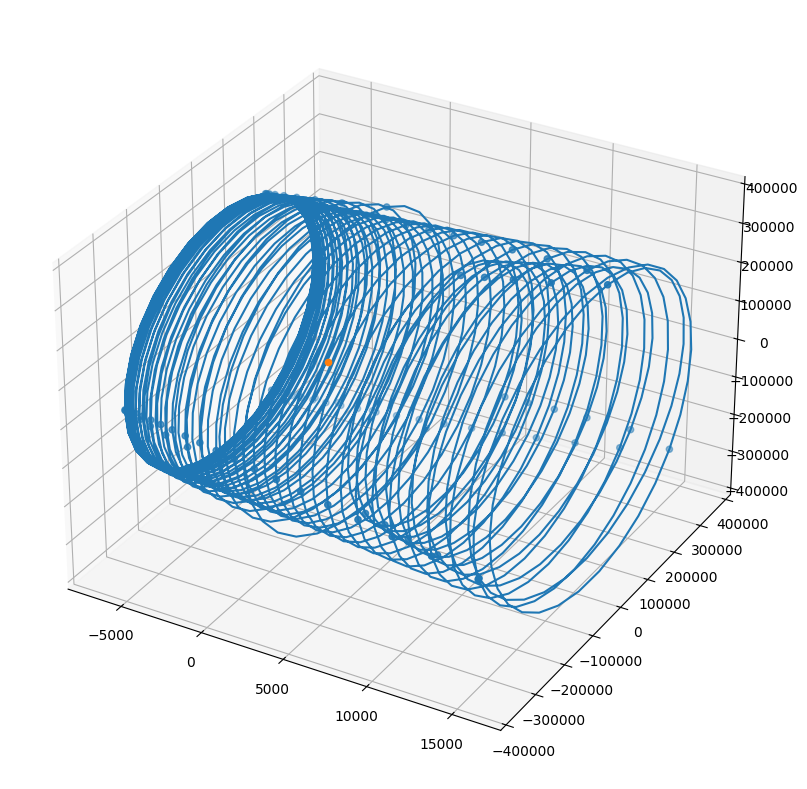

In [35]:
#obs     = Observation(deltaT_sec=60)
#S       = Satellite()
#obsat   = ObservedSatellite(obs, S)

# fig, (p1, p2) = plt.subplots(1,2)
fig = plt.figure(figsize=plt.figaspect(0.5))
#fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [12., 6.]
#plt.rcParams["figure.autolayout"] = True


ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot3D(obsat.posxyz[:2000,0], obsat.posxyz[:2000,1], obsat.posxyz[:2000,2])
ax.scatter3D(obsat.posxyz[:2000:20,0], obsat.posxyz[:2000:20,1], obsat.posxyz[:2000:20,2])
_ = ax.scatter3D(0,0,0)

In [1]:
# ---- just keep for later
# fig     = plt.figure(figsize=(20,10))
# plt.rcParams["figure.autolayout"] = True
# ax      = plt.axes(projection='3d')
# posxyz  = obsat.posxyz

# ax.plot3D(posxyz[:2000,0],posxyz[:2000,1],posxyz[:2000,2])
# ax.scatter3D(posxyz[:2000:20,0],posxyz[:2000:20,1],posxyz[:2000:20,2])
# _ = ax.scatter3D(0,0,0)

# ax = fig.add_subplot(1, 2, 2)
# obsat.plot_tracks(ax)
# plt.show()


Text(0, 0.5, 'N-S')

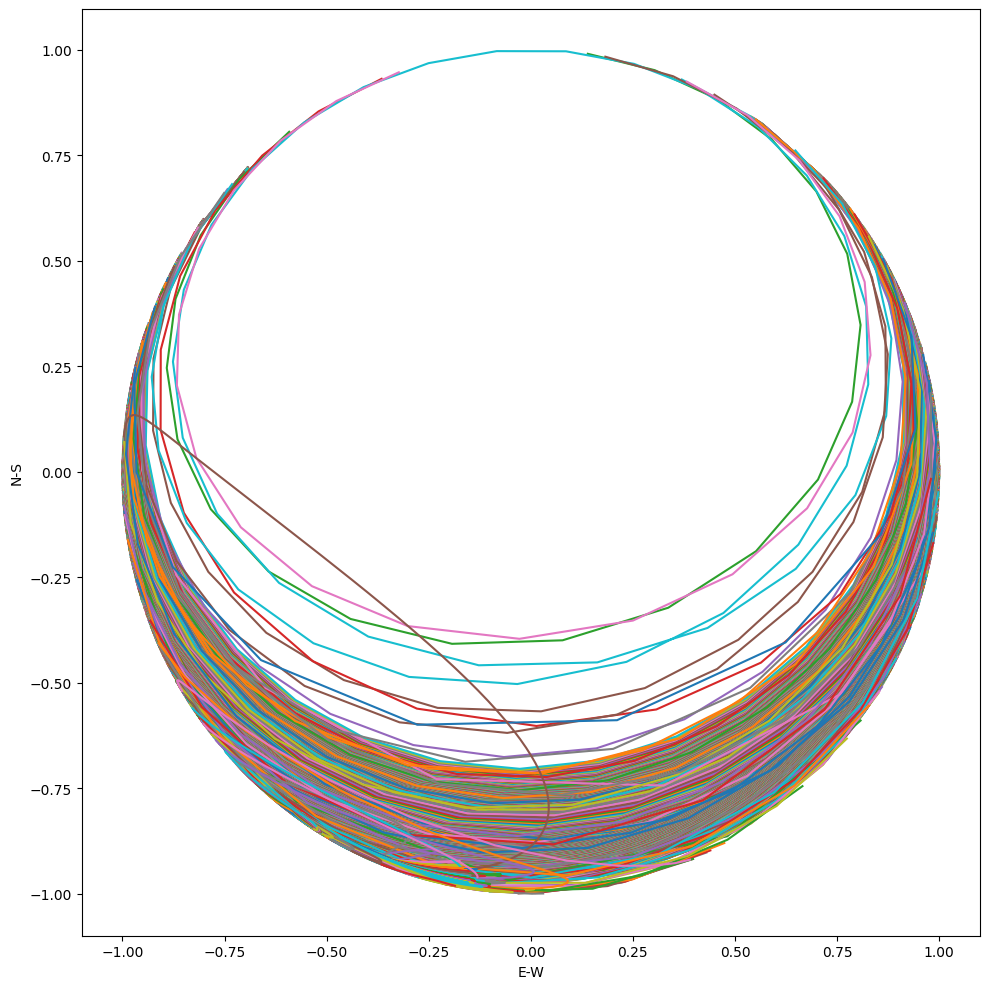

In [36]:
plt.figure(figsize=(10,10))
obsat.plot_tracks(plt)
plt.xlabel("E-W")
plt.ylabel("N-S")

In [24]:
transits = obsat.get_transit_indices()
print (len(transits))

55


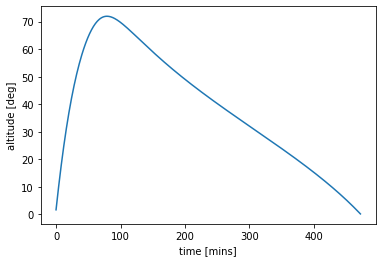

In [7]:
# Take transit #5
i,j = transits[5]
plt.plot(np.arange(j-i),obsat.alt_rad()[i:j]/np.pi*180)
plt.xlabel('time [mins]')
plt.ylabel('altitude [deg]')
pass